In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import pingouin as pg

In [740]:
train_data_filename = "ВДНХ_2005_2024.csv"

In [741]:
historic_data = pd.read_csv(train_data_filename, encoding='utf-8', sep=";", index_col=False, header=0)

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\4060381719.py:1: DtypeWarning: Columns (21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  historic_data = pd.read_csv(train_data_filename, encoding='utf-8', sep=";", index_col=False, header=0)


In [742]:
historic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67039 entries, 0 to 67038
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Местное время в Москве (ВДНХ)  67039 non-null  object 
 1   T                              67032 non-null  float64
 2   Po                             66865 non-null  float64
 3   P                              66904 non-null  float64
 4   Pa                             43949 non-null  float64
 5   U                              66995 non-null  float64
 6   DD                             66989 non-null  object 
 7   Ff                             66989 non-null  float64
 8   ff10                           195 non-null    float64
 9   ff3                            1471 non-null   float64
 10  N                              63307 non-null  object 
 11  WW                             67039 non-null  object 
 12  W1                             30566 non-null 

In [743]:
if "timestamp" not in historic_data.columns:
    historic_data = historic_data.rename(columns={'Местное время в Москве (ВДНХ)':'timestamp'})

historic_data['timestamp'] = pd.to_datetime(historic_data['timestamp'], dayfirst=True)
historic_data['year'] = historic_data.timestamp.dt.year
historic_data['month'] = historic_data.timestamp.dt.month
historic_data['day'] = historic_data.timestamp.dt.dayofyear


In [744]:
historic_data[historic_data["T"].isna()]

,timestamp,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Td,RRR,tR,E,Tg,E',sss,year,month,day
7910,2022-04-17 12:00:00,NaN,753.3,767.3,NaN,NaN,"Штиль, безветрие",0.0,NaN,NaN,...,-6.2,NaN,NaN,NaN,NaN,NaN,NaN,2022,4,107
13069,2020-07-11 09:00:00,NaN,746.1,760.8,-4.8,NaN,"Ветер, дующий с северо-запада",2.0,NaN,NaN,...,-1.4,Осадков нет,12.0,NaN,NaN,NaN,NaN,2020,7,193
44401,2013-01-20 00:00:00,NaN,742.0,757.8,NaN,NaN,"Штиль, безветрие",0.0,NaN,NaN,...,-18.8,NaN,NaN,NaN,NaN,NaN,NaN,2013,1,20
51826,2010-07-03 03:00:00,NaN,746.0,759.6,NaN,NaN,"Ветер, дующий с северо-северо-востока",1.0,NaN,NaN,...,16.1,NaN,NaN,NaN,NaN,NaN,NaN,2010,7,184
52873,2010-02-21 09:00:00,NaN,737.8,753.4,NaN,NaN,NaN,NaN,NaN,NaN,...,-17.9,8.0,12.0,NaN,NaN,Ровный слой сухого рассыпчатого снега покрывае...,59.0,2010,2,52
61799,2007-01-22 09:00:00,NaN,731.7,746.0,NaN,NaN,"Штиль, безветрие",0.0,NaN,NaN,...,-0.6,Следы осадков,12.0,NaN,NaN,Ровный слой слежавшегося или мокрого снега пок...,7.0,2007,1,22
66282,2005-07-04 12:00:00,NaN,748.0,761.6,NaN,NaN,"Ветер, дующий с северо-северо-востока",1.0,NaN,NaN,...,7.3,NaN,NaN,NaN,NaN,NaN,NaN,2005,7,185


### Ненужные колонки

In [745]:
# Tn - минимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов). Практически пустая
# Tx - максимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов). Практически пустая
# Td - нет описания в исходниках. Вероятно какая-то разница температур
# Ff10 - FF10, максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за 10-минутный период, непосредственно предшествующий сроку наблюдения (метры в секунду). Практически пустая
# Ff3 - максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за период между сроками (метры в секунду). Почти пустая
# Nh - сильная корреляция с N и при этом больше пропущенных значений
historic_data = historic_data.drop(["Tn", "Tx", "Td", "ff10", "ff3", "Nh"], axis=1)

## Заполнение недостающих данных

In [746]:
def get_missing_values():
    missing_values_by_columns = historic_data.isna().sum(axis=0).sort_values()
    return missing_values_by_columns[missing_values_by_columns > 0]

In [747]:
get_missing_values()

T          7
U         44
Ff        50
DD        50
P        135
Po       174
N       3732
H      13425
Cl     16400
Pa     23090
VV     25662
Cm     34439
W1     36473
W2     36473
Ch     37910
tR     45541
RRR    45542
E      63939
E'     64358
Tg     64556
sss    64582
dtype: int64

### T: температура

In [748]:
# Взял с другого сайта
historic_data.loc[7910, "T"] = 5.4
historic_data.loc[13069, "T"] = 24
historic_data.loc[44401, "T"] = -21
historic_data.loc[51826, "T"] = 19
historic_data.loc[52873, "T"] = -16
historic_data.loc[61799, "T"] = 1
historic_data.loc[66282, "T"] = 21

### U (относительная влажность (%) на высоте 2 метра над поверхностью земли)

In [749]:
historic_data["U"].mean(), historic_data["U"].median()

(np.float64(75.26846779610419), np.float64(80.0))

In [750]:
U_by_month = historic_data[["U", "month"]].groupby("month").mean().reset_index()

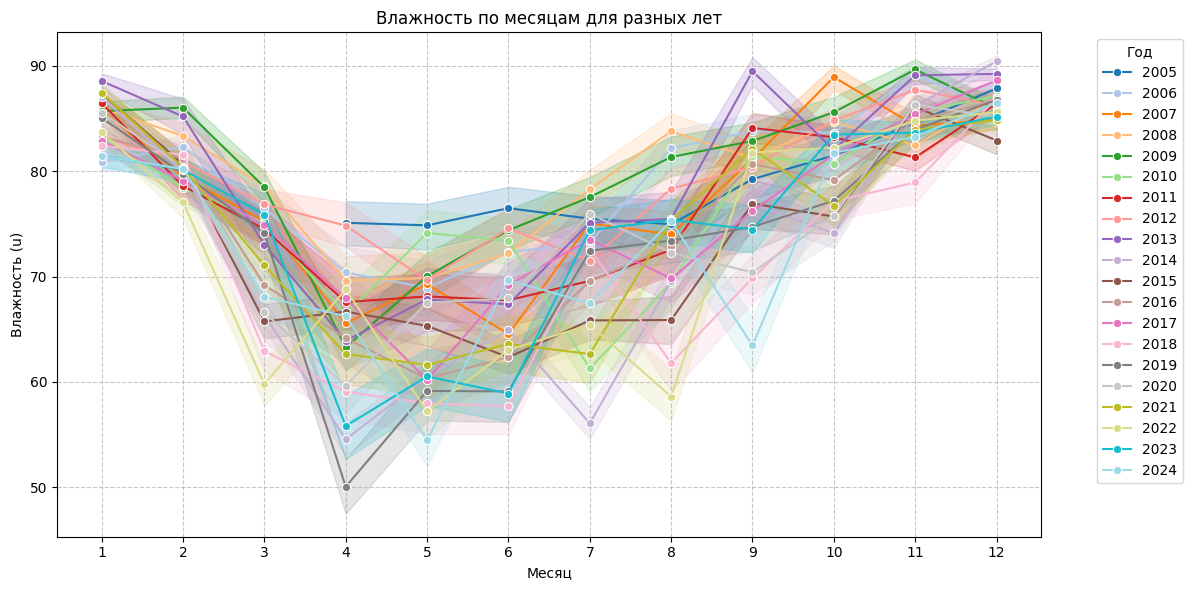

In [751]:
# Тут на графике видно, что влажность падает летом, осенью и весной средняя и самая высокая зимой

plt.figure(figsize=(12, 6))

sns.lineplot(data=historic_data, x='month', y='U', hue='year',
             marker='o', palette='tab20')

plt.title('Влажность по месяцам для разных лет')
plt.xlabel('Месяц')
plt.ylabel('Влажность (u)')
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Год', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [752]:
# Заполняем влажность по месяцам
historic_data['U'] = historic_data.groupby('month')['U'].transform(lambda x: x.fillna(x.mean()))

In [753]:
historic_data['U'].isna().sum()

np.int64(0)

### FF, cкорость ветра на высоте 10-12 метров над земной поверхностью, осредненная за 10-минутный период, непосредственно предшествовавший сроку наблюдения (метры в секунду)
### DD - направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период, непосредственно предшествовавший сроку наблюдения

In [754]:
historic_data

,timestamp,T,Po,P,Pa,U,DD,Ff,N,WW,...,VV,RRR,tR,E,Tg,E',sss,year,month,day
0,2024-12-31 21:00:00,-2.2,741.4,755.5,0.5,86.0,"Ветер, дующий с западо-юго-запада",1.0,40%.,,...,20.0,5.0,12.0,NaN,NaN,NaN,NaN,2024,12,366
1,2024-12-31 18:00:00,-0.8,740.9,754.9,1.3,88.0,"Ветер, дующий с западо-юго-запада",1.0,"90 или более, но не 100%",,...,20.0,5.0,12.0,NaN,NaN,NaN,NaN,2024,12,366
2,2024-12-31 15:00:00,-1.0,739.6,753.7,0.4,93.0,"Ветер, дующий с запада",1.0,40%.,Облака в целом рассеиваются или становятся мен...,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,366
3,2024-12-31 12:00:00,-0.3,739.2,753.1,-1.2,96.0,"Ветер, дующий с северо-северо-запада",1.0,100%.,Ливневый снег умеренный или сильный в срок наб...,...,1.3,NaN,NaN,NaN,NaN,NaN,NaN,2024,12,366
4,2024-12-31 09:00:00,0.7,740.4,754.3,-1.8,84.0,"Ветер, дующий с юго-юго-запада",1.0,100%.,,...,20.0,0.7,12.0,NaN,NaN,Ровный слой слежавшегося или мокрого снега пок...,6.0,2024,12,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67034,2005-04-01 12:00:00,2.5,756.6,771.4,NaN,55.0,"Ветер, дующий с северо-запада",2.0,"90 или более, но не 100%",,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,2005,4,91
67035,2005-04-01 09:00:00,-0.2,756.2,771.2,NaN,71.0,"Ветер, дующий с северо-северо-запада",1.0,20–30%.,Дымка.,...,10.0,NaN,NaN,NaN,NaN,Ровный слой слежавшегося или мокрого снега пок...,50.0,2005,4,91
67036,2005-04-01 06:00:00,-5.2,755.6,770.7,NaN,90.0,"Ветер, дующий с северо-северо-запада",2.0,Облаков нет.,Дымка.,...,4.0,Следы осадков,12.0,NaN,NaN,NaN,NaN,2005,4,91
67037,2005-04-01 03:00:00,-2.3,755.2,770.2,NaN,80.0,"Ветер, дующий с северо-запада",2.0,Облаков нет.,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,4,91


In [755]:
historic_data['timestamp'] = pd.to_datetime(historic_data['timestamp'])
# Сортируем, чтобы interpolate по времени сработало
historic_data = historic_data.sort_values('timestamp')
historic_data = historic_data.set_index('timestamp')

# Интерполяция
historic_data['Ff'] = historic_data['Ff'].interpolate(method='time')

historic_data = historic_data.reset_index()

In [756]:
# Ветер заполняем предыдущим значением
historic_data['DD'] = historic_data['DD'].fillna(method='ffill')

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\270258539.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historic_data['DD'] = historic_data['DD'].fillna(method='ffill')


### P, атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)
### P0, атмосферное давление на уровне станции (миллиметры ртутного столба)

In [757]:
# Разница между "P" и "Po"
historic_data["P_diff"] = historic_data["P"] - historic_data["Po"]

In [758]:
((historic_data["P_diff"] >= 13) & (historic_data["P_diff"] <= 17)).sum()

np.int64(66102)

<Axes: xlabel='P_diff'>

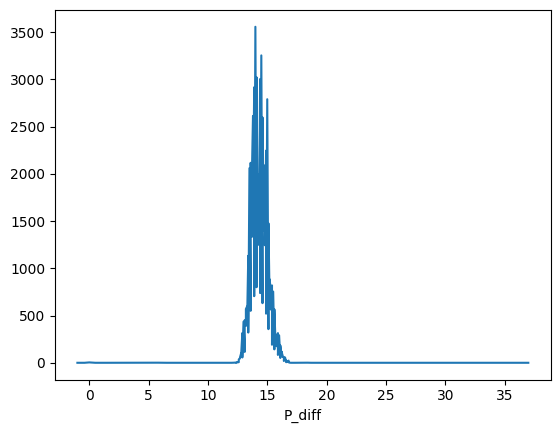

In [759]:
# Практически всегда значения находятся от 13 до 17
historic_data["P_diff"].value_counts().sort_index().plot()

In [760]:
_mean = historic_data["P_diff"].mean()
_median = historic_data["P_diff"].median()

In [761]:
# Медиана и средняя практически равны
_mean, _median

(np.float64(14.340895901884533), np.float64(14.299999999999955))

In [762]:
P_missing = historic_data["P"].isna()
Po_missing = historic_data["Po"].isna()

In [763]:
# Если заполнен один из показателей, то заполняем другой сложением/вычитание средней разницы
mask_only_Po_missing = ~P_missing & Po_missing
historic_data.loc[mask_only_Po_missing, "Po"] = historic_data.loc[mask_only_Po_missing, "P"] - _mean
mask_only_P_missing = P_missing & ~Po_missing
historic_data.loc[mask_only_P_missing, "P"] = historic_data.loc[mask_only_P_missing, "Po"] + _mean

In [764]:
historic_data["Po"].isna().sum()

np.int64(130)

In [765]:
historic_data["P"].isna().sum()

np.int64(130)

In [766]:
historic_data = historic_data.sort_values('timestamp')
historic_data = historic_data.set_index('timestamp')

# Интерполяция
historic_data['Po'] = historic_data['Po'].interpolate(method='time')
historic_data['P'] = historic_data['P'].interpolate(method='time')

In [767]:
historic_data["P"].isna().sum(), historic_data["Po"].isna().sum()

(np.int64(0), np.int64(0))

In [768]:
historic_data.drop(["P_diff"], axis=1, inplace=True)

### N - в изначальных данных не сказано, но это показатель облаков

In [769]:
def get_N(x):
  if x == "40%":
    return 0.40

  if x == '90  или более, но не 100%':
    return 0.95

  if x == '100%.':
    return 1.00

  if x == '60%.':
    return 0.60

  if x == '50%.':
    return 0.50

  if x == '70 – 80%.':
    return 0.75

  if x == 'Облаков нет.':
    return 0

  if x == '40%.':
    return 0.4

  if x == '20–30%.':
    return 0.25

  if x == '10%  или менее, но не 0':
    return 0.05

  if x == 'Небо не видно из-за тумана и/или других метеорологических явлений.':
    return np.nan

  return x

historic_data["N"] = historic_data["N"] = historic_data["N"].apply(get_N)

In [770]:
historic_data["N"]

timestamp
2005-04-01 00:00:00    0.95
2005-04-01 03:00:00    0.00
2005-04-01 06:00:00    0.00
2005-04-01 09:00:00    0.25
2005-04-01 12:00:00    0.95
                       ... 
2024-12-31 09:00:00    1.00
2024-12-31 12:00:00    1.00
2024-12-31 15:00:00    0.40
2024-12-31 18:00:00    0.95
2024-12-31 21:00:00    0.40
Name: N, Length: 67039, dtype: float64

In [771]:
historic_data['N'] = historic_data['N'].fillna(method='ffill')

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\2146368672.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historic_data['N'] = historic_data['N'].fillna(method='ffill')


### H - высота основания самых низких облаков

In [772]:
def get_H(x):
  if x == "600-1000":
    return 800

  if x == '2500 или более, или облаков нет.':
    return 2600

  if x == '1000-1500':
    return 1250

  if x == '300-600':
    return 450

  if x == '200-300':
    return 250

  if x == '100-200':
    return 150

  if x == '50-100':
    return 75

  if x == '1500-2000':
    return 1750

  if x == 'Менее 50':
    return 40

  if x == '2000-2500':
    return 2250

  return x

historic_data["H"] = historic_data["H"].apply(get_H)

In [773]:
historic_data["H"].isna().sum()

np.int64(13425)

In [774]:
print(historic_data['H'].corr(historic_data['T']))

0.12983326223972763


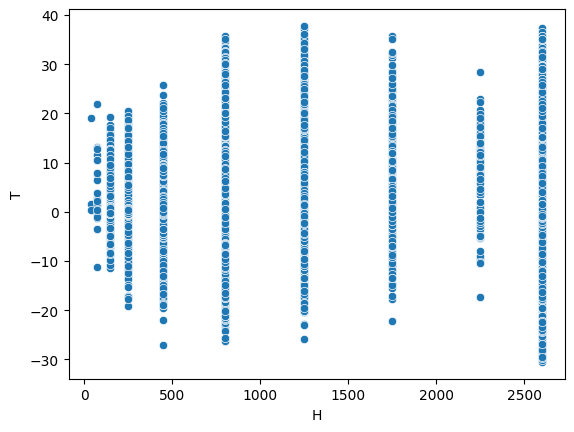

In [775]:
sns.scatterplot(x='H', y='T', data=historic_data)
plt.show()

In [776]:
print(historic_data[['H', 'T', 'U', 'P', 'Ff']].corr())

           H         T         U         P        Ff
H   1.000000  0.129833 -0.340446  0.217161 -0.162809
T   0.129833  1.000000 -0.428482 -0.203530 -0.078440
U  -0.340446 -0.428482  1.000000 -0.137851 -0.224973
P   0.217161 -0.203530 -0.137851  1.000000 -0.145992
Ff -0.162809 -0.078440 -0.224973 -0.145992  1.000000


In [777]:
historic_data = historic_data.drop(columns=['H'])

### Cl - в исходниках нет описания. В инете: Это классификация нижнего яруса облачности, которая описывает форму и вид облаков, находящихся ниже 2 км от поверхности

In [778]:
historic_data["Cl"]

timestamp
2005-04-01 00:00:00       Слоисто-кучевые, образовавшиеся не из кучевых.
2005-04-01 03:00:00                                                  NaN
2005-04-01 06:00:00                                                  NaN
2005-04-01 09:00:00                                                  NaN
2005-04-01 12:00:00          Слоисто-кучевые, образовавшиеся из кучевых.
                                             ...                        
2024-12-31 09:00:00       Слоисто-кучевые, образовавшиеся не из кучевых.
2024-12-31 12:00:00    Кучево-дождевые волокнистые (часто с наковальн...
2024-12-31 15:00:00       Слоисто-кучевые, образовавшиеся не из кучевых.
2024-12-31 18:00:00       Слоисто-кучевые, образовавшиеся не из кучевых.
2024-12-31 21:00:00       Слоисто-кучевые, образовавшиеся не из кучевых.
Name: Cl, Length: 67039, dtype: object

In [779]:
historic_data["Cl"].value_counts(normalize=True)

Cl
Слоисто-кучевые, образовавшиеся не из кучевых.                                                                                                                                             0.372835
Слоистые разорванные или кучевые разорванные облака плохой погоды, либо те и другие вместе (разорванно-дождевые); обычно расположены под слоистыми или слоисто-дождевыми облаками.         0.146804
Слоисто-кучевых, слоистых, кучевых или кучево-дождевых облаков нет.                                                                                                                        0.145264
Слоисто-кучевые, образовавшиеся из кучевых.                                                                                                                                                0.071546
Кучевые и слоисто-кучевые (но не слоисто-кучевые, образовавшиеся из кучевых), основания расположены на разных уровнях.                                                                     0.067122
Слоистые туманооб

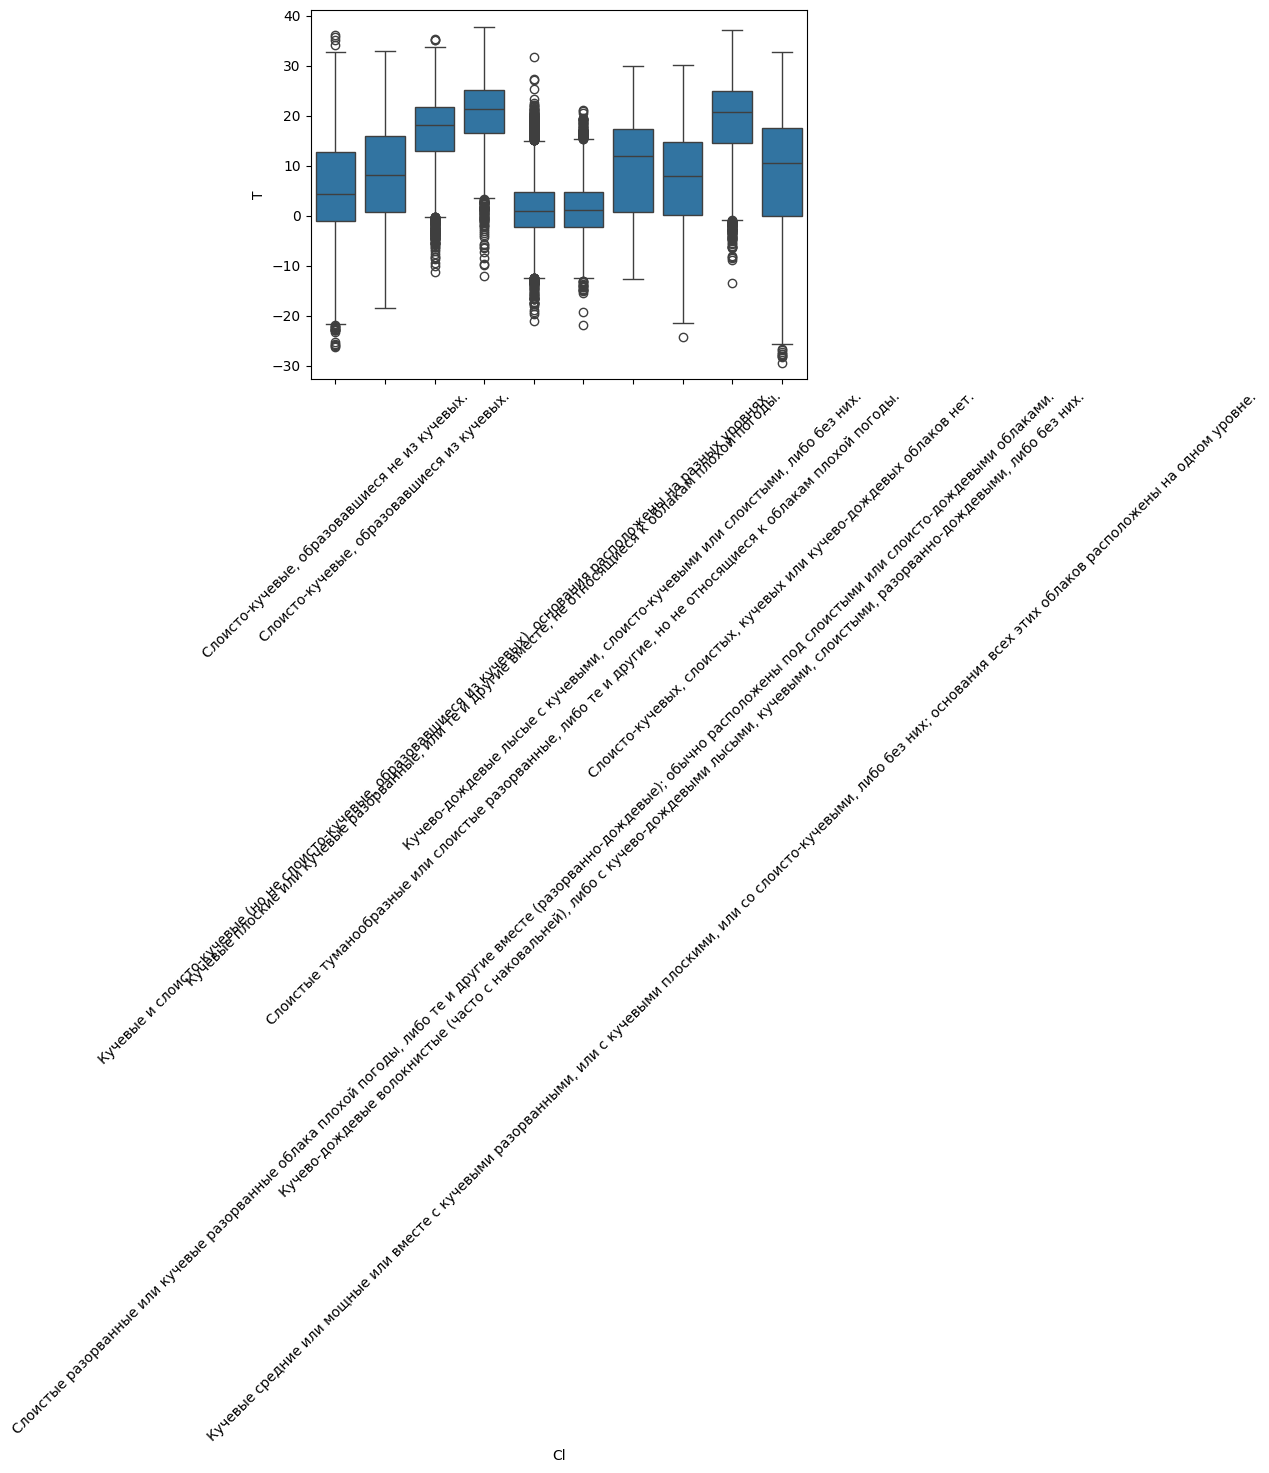

In [780]:
sns.boxplot(x='Cl', y='T', data=historic_data)
plt.xticks(rotation=45)
plt.show()

In [781]:
historic_data['Cl'].fillna('Неизвестно', inplace=True)

### Pa - В исходниках нет описания. Вероятно атмосферное давление

In [782]:
historic_data["Pa"]

timestamp
2005-04-01 00:00:00    NaN
2005-04-01 03:00:00    NaN
2005-04-01 06:00:00    NaN
2005-04-01 09:00:00    NaN
2005-04-01 12:00:00    NaN
                      ... 
2024-12-31 09:00:00   -1.8
2024-12-31 12:00:00   -1.2
2024-12-31 15:00:00    0.4
2024-12-31 18:00:00    1.3
2024-12-31 21:00:00    0.5
Name: Pa, Length: 67039, dtype: float64

In [783]:
historic_data[["Pa", "T"]].corr()

,Pa,T
Pa,1.000000,-0.086045
T,-0.086045,1.000000


In [784]:
print(historic_data['Pa'].describe())

count    43949.000000
mean        -0.001941
std          0.905618
min        -13.400000
25%         -0.500000
50%          0.000000
75%          0.500000
max          9.900000
Name: Pa, dtype: float64


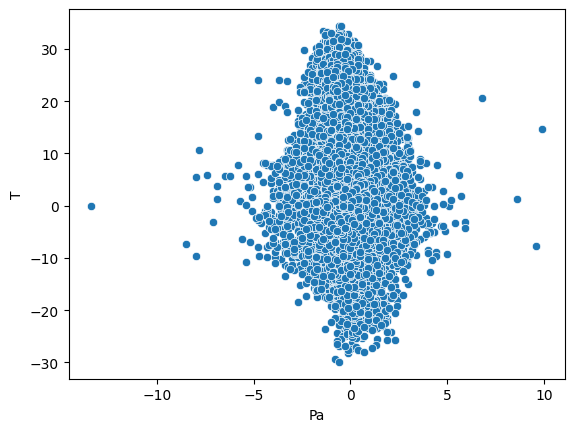

In [785]:
sns.scatterplot(x='Pa', y='T', data=historic_data)
plt.show()

In [786]:
historic_data[['T', 'P', 'Po', 'U', 'N', 'Pa']].corr()

,T,P,Po,U,N,Pa
T,1.000000,-0.203530,-0.131558,-0.428482,-0.144332,-0.086045
P,-0.203530,1.000000,0.996374,-0.137851,-0.281534,0.061041
Po,-0.131558,0.996374,1.000000,-0.169386,-0.294805,0.056479
U,-0.428482,-0.137851,-0.169386,1.000000,0.295041,0.090490
N,-0.144332,-0.281534,-0.294805,0.295041,1.000000,-0.066392
Pa,-0.086045,0.061041,0.056479,0.090490,-0.066392,1.000000


In [787]:
historic_data.drop(columns=['Pa'], inplace=True)

### VV - горизонтальная дальность видимости

In [788]:
def get_VV(x):
    if x == "менее 0.1":
        return 0.05
    
    return x


historic_data["VV"] = historic_data["VV"].apply(get_VV)

In [789]:
historic_data[["VV", "T"]].corr()

,VV,T
VV,1.000000,0.122173
T,0.122173,1.000000


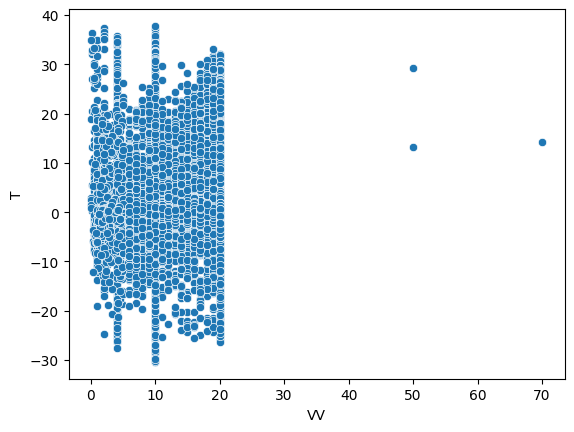

In [790]:
sns.scatterplot(x='VV', y='T', data=historic_data)
plt.show()

In [791]:
historic_data.drop(columns=['VV'], inplace=True)

In [792]:
get_missing_values()

Cm     34439
W2     36473
W1     36473
Ch     37910
tR     45541
RRR    45542
E      63939
E'     64358
Tg     64556
sss    64582
dtype: int64

### Cm

In [793]:
historic_data["Cm"]

timestamp
2005-04-01 00:00:00    Высококучевые просвечивающие, расположенные на...
2005-04-01 03:00:00                                                  NaN
2005-04-01 06:00:00                                                  NaN
2005-04-01 09:00:00                                                  NaN
2005-04-01 12:00:00                                                  NaN
                                             ...                        
2024-12-31 09:00:00                                                  NaN
2024-12-31 12:00:00                                                  NaN
2024-12-31 15:00:00    Высококучевых, высокослоистых или слоисто-дожд...
2024-12-31 18:00:00    Высококучевых, высокослоистых или слоисто-дожд...
2024-12-31 21:00:00    Высококучевых, высокослоистых или слоисто-дожд...
Name: Cm, Length: 67039, dtype: object

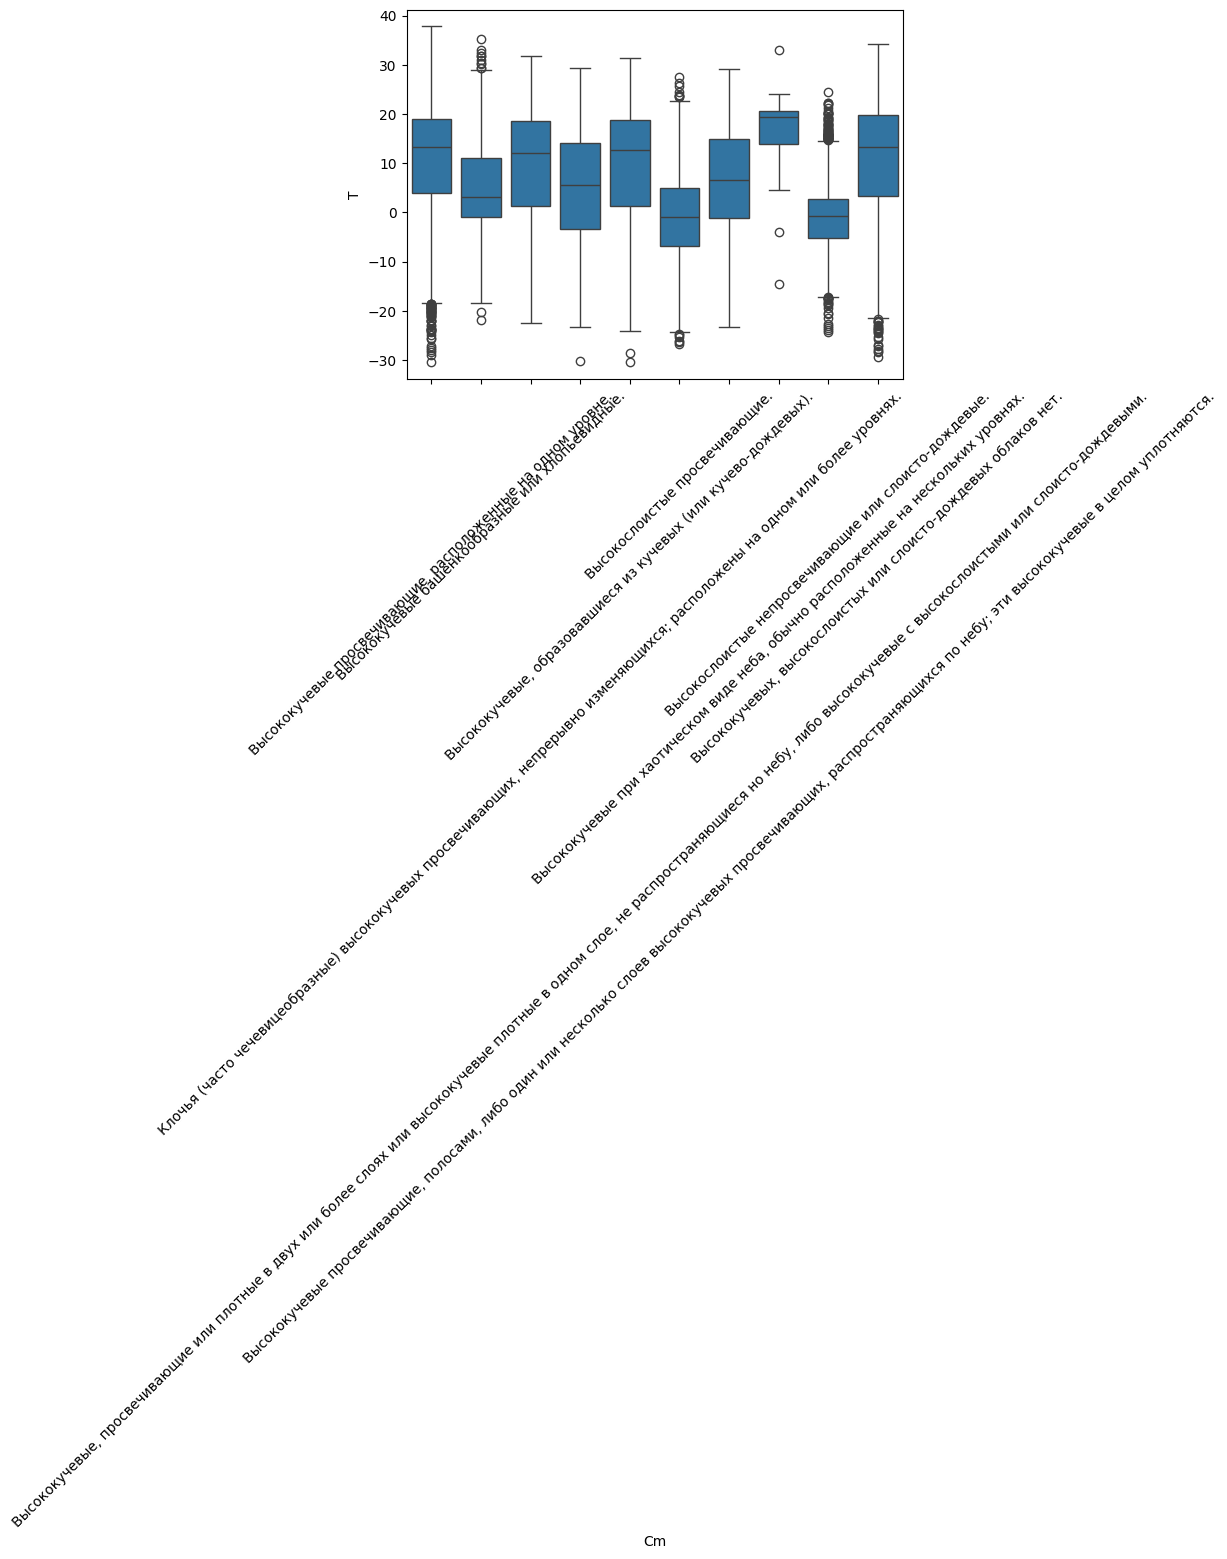

In [794]:
sns.boxplot(x='Cm', y='T', data=historic_data)
plt.xticks(rotation=45)
plt.show()

In [795]:
historic_data["Cm"].value_counts(normalize=True)

Cm
Высококучевых, высокослоистых или слоисто-дождевых облаков нет.                                                                                                                                        0.419080
Высококучевые просвечивающие, расположенные на одном уровне.                                                                                                                                           0.189141
Высококучевые башенкообразные или хлопьевидные.                                                                                                                                                        0.181534
Высокослоистые непросвечивающие или слоисто-дождевые.                                                                                                                                                  0.084785
Высокослоистые просвечивающие.                                                                                                                                       

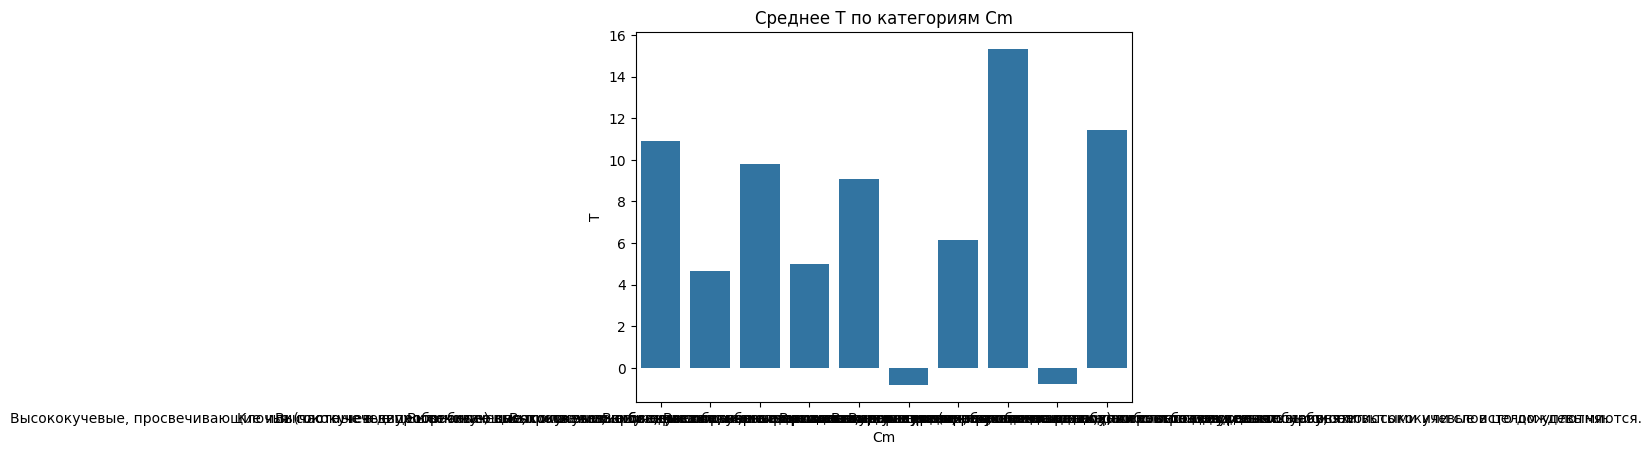

In [796]:
sns.barplot(data=historic_data, x="Cm", y="T", estimator="mean", errorbar=None)
plt.title("Среднее T по категориям Cm")
plt.show()

In [ ]:
# Рассчёт размера эффекта
anova_results = pg.anova(data=historic_data, dv="T", between="Cm")
eta_squared = anova_results["np2"][0]  # η² (нормализованный коэффициент)
print(f"Eta-squared: {eta_squared:.3f}")

Eta-squared: 0.155


In [798]:
historic_data['Cm'].fillna('Неизвестно', inplace=True)

### Оставшиеся

Предварительно я удалил их, т.к. в них слишком много пропусков, но к этому можно еще вернуться

In [799]:
historic_data.drop(columns=list(get_missing_values().index), inplace=True)

## Обработка данных

In [801]:
historic_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67039 entries, 2005-04-01 00:00:00 to 2024-12-31 21:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       67039 non-null  float64
 1   Po      67039 non-null  float64
 2   P       67039 non-null  float64
 3   U       67039 non-null  float64
 4   DD      67039 non-null  object 
 5   Ff      67039 non-null  float64
 6   N       67039 non-null  float64
 7   WW      67039 non-null  object 
 8   Cl      67039 non-null  object 
 9   Cm      67039 non-null  object 
 10  year    67039 non-null  int32  
 11  month   67039 non-null  int32  
 12  day     67039 non-null  int32  
dtypes: float64(6), int32(3), object(4)
memory usage: 6.4+ MB


In [802]:
historic_data['month_sin'] = np.sin(np.pi * (historic_data['month'] - 1) / 11)
historic_data['month_cos'] = np.cos(np.pi * (historic_data['month'] - 1) / 11)

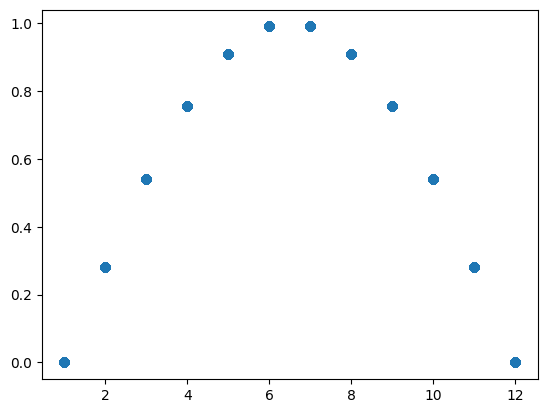

In [803]:
plt.scatter(historic_data['month'], historic_data['month_sin'])

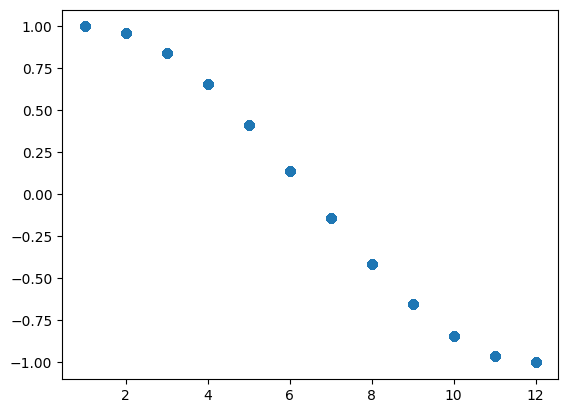

In [804]:
plt.scatter(historic_data['month'], historic_data['month_cos'])

In [805]:
historic_data.drop(columns=['month'], inplace=True)

In [807]:
cat_features = list(historic_data.select_dtypes(include=['object']).columns)

In [808]:
number_features = list(historic_data.select_dtypes(include=['float64', 'int32']).columns)

# Их не нужно нормализовывать
number_features.remove("month_sin")
number_features.remove("month_cos")
# Нормализуем отдельно
number_features.remove("year")
number_features.remove("day")
number_features.remove("T")

In [809]:
historic_data = pd.get_dummies(historic_data, columns=cat_features, prefix=cat_features)

In [810]:
scalerX = MinMaxScaler()
scaler_year = MinMaxScaler()
scaler_day = MinMaxScaler()
scaler_T = MinMaxScaler()

# Применяем нормализацию к выбранным колонкам
historic_data[number_features] = scalerX.fit_transform(historic_data[number_features])
historic_data["year"] = scaler_year.fit_transform([[year] for year in historic_data["year"]])
historic_data["day"] = scaler_day.fit_transform([[day] for day in historic_data["day"]])
historic_data["T"] = scaler_T.fit_transform([[T] for T in historic_data["T"]])

# Проверяем результат
print(historic_data[number_features].describe())

                 Po             P             U            Ff             N
count  67039.000000  67039.000000  67039.000000  67039.000000  67039.000000
mean       0.538131      0.527082      0.718936      0.144533      0.700054
std        0.116055      0.115456      0.210731      0.117558      0.384937
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.466667      0.456268      0.590909      0.000000      0.400000
50%        0.537879      0.523324      0.772727      0.125000      0.950000
75%        0.609091      0.596210      0.886364      0.250000      1.000000
max        1.000000      1.000000      1.000000      1.000000      1.000000


In [811]:
historic_data.reset_index(inplace=True)

In [812]:
hours = historic_data['timestamp'].dt.hour
historic_data['hour_sin'] = np.sin(np.pi * hours / 23)
historic_data['hour_cos'] = np.sin(np.pi * hours / 23)


In [815]:
interpolate_columns = list(historic_data.columns)
interpolate_columns.remove("month_sin")
interpolate_columns.remove("month_cos")
interpolate_columns.remove("year")
interpolate_columns.remove("day")
interpolate_columns.remove("timestamp")
interpolate_columns.remove("hour_sin")
interpolate_columns.remove("hour_cos")


## Интерполяция

In [ ]:
def prepare_future_data():
    """
    Подготавливает DataFrame с данными для прогнозирования на указанный год
    с учетом преобразования месяца и нормализации года.
    """

    future_data = pd.DataFrame()
    
    future_data['day'] = np.array((list(np.arange(1, 366, 1)) * 8))
    future_data['year'] = 2025
    future_data['hours'] = np.array((list(np.arange(0, 23, 3)) * 365))

    days_in_month_2025 = [
        31,    # Январь
        28,    # Февраль (2025 — невисокосный)
        31,    # Март
        30,    # Апрель
        31,    # Май
        30,    # Июнь
        31,    # Июль
        31,    # Август
        30,    # Сентябрь
        31,    # Октябрь
        30,    # Ноябрь
        31     # Декабрь
    ]

    monthes = []
    for i, day in enumerate(days_in_month_2025):
        monthes.extend(list([i+1] * day * 8)) 

    future_data['month'] = monthes
    
    future_data['month_sin'] = np.sin(np.pi * (future_data['month'] - 1) / 11)
    future_data['month_cos'] = np.cos(np.pi * (future_data['month'] - 1) / 11)
    future_data['hour_sin'] = np.sin(np.pi * (future_data['hours']) / 23)
    future_data['hour_cos'] = np.cos(np.pi * (future_data['hours']) / 23)
    future_data["day"] = scaler_day.transform([[day] for day in future_data["day"]])
    future_data['year'] = scaler_year.transform([[year] for year in future_data["year"]])
    
    return future_data

def interpolate_with_catboost(historic_data, target_columns):

    historic_data = historic_data.copy()
    
    future_data = prepare_future_data()
    
    base_features = ['year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']
    
    for column in target_columns:
        X_train = historic_data[base_features]
        y_train = historic_data[column]
        
        model = CatBoostRegressor(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            verbose=0
        )
        model.fit(X_train, y_train)
        
        future_data[column] = model.predict(future_data[base_features])
    
    return future_data

In [ ]:
future_predictions = interpolate_with_catboost(
    historic_data=historic_data,
    target_columns=interpolate_columns
)

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\3887005655.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[column] = model.predict(future_data[features])
C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\3887005655.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[column] = model.predict(future_data[features])
C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\3887005655.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [818]:
future_predictions["T_interpolated"] = scaler_T.inverse_transform([[T] for T in future_predictions["T"]])

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\467275735.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_predictions["T_interpolated"] = scaler_T.inverse_transform([[T] for T in future_predictions["T"]])


In [819]:
real_data = [-0.4, -4.4, 4.6, 8.2]
interpolated_result = future_predictions.groupby("month")["T_interpolated"].mean()

In [820]:
base_features = ['year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']

## Предсказание

In [ ]:
X_train = historic_data[[*interpolate_columns, *base_features]]
y_train = historic_data["T"]

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=0
)
model.fit(X_train, y_train)
predictions_T = model.predict(future_predictions[[*interpolate_columns, *base_features]])

In [822]:
future_predictions["T_predicted"]  = scaler_T.inverse_transform([[T] for T in predictions_T])

C:\Users\Sherb\AppData\Local\Temp\ipykernel_20644\2747107835.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_predictions["T_predicted"]  = scaler_T.inverse_transform([[T] for T in predictions_T])


In [823]:
predicted_result = future_predictions.groupby("month")["T_predicted"].mean()

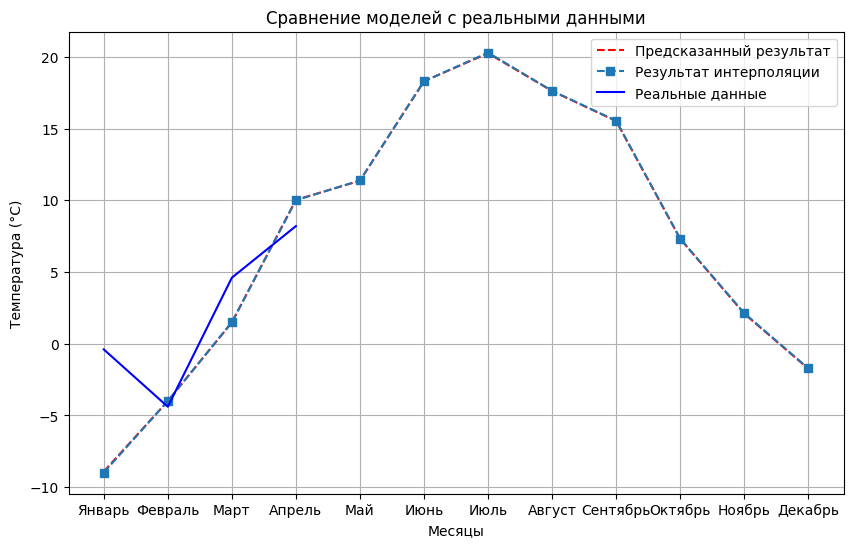

In [828]:
months = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
real_data = [-0.4, -4.4, 4.6, 8.2]

plt.figure(figsize=(10, 6))

plt.plot(months, predicted_result, 'r--', label='Предсказанный результат')
plt.plot(months, interpolated_result, 's--', label='Результат интерполяции')
plt.plot(months[:4], real_data, 'b-', label='Реальные данные')

plt.title('Сравнение моделей с реальными данными')
plt.xlabel('Месяцы')
plt.ylabel('Температура (°C)')
plt.legend()
plt.grid(True)

plt.show()